Импроты и инициализация spark

In [218]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
import time
import pandas as pd
from pyspark.sql import SparkSession
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

conf = SparkConf()
conf.setAppName('My spark')
conf.setMaster('local[*]')

sc=SparkContext.getOrCreate(conf=conf)
spark= SparkSession.builder.getOrCreate()

print(conf.toDebugString())

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


spark.app.name=My spark
spark.master=local[*]
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


In [216]:
path_to_file = 'PAMAP2_Dataset\Optional\subject101.dat'

activity_val_name = {
    1  : 'lying',
    2  : 'sitting',
    3  : 'standing',
    4  : 'walking',
    5  : 'running',
    6  : 'cycling',
    7  : 'Nordic walking',
    9  : 'watching TV',
    10 : 'computer work',
    11 : 'car driving',
    12 : 'ascending stairs',
    13 : 'descending stairs',
    16 : 'vacuum cleaning',
    17 : 'ironing',
    18 : 'folding laundry',
    19 : 'house cleaning',
    20 : 'playing soccer',
    24 : 'rope jumping',
    0  : 'other (transient activities)',
}

activity_name_val = {
    'lying' : 1 ,
    'sitting' : 2 ,
    'standing' : 3 ,
    'walking' : 4 ,
    'running' : 5 ,
    'cycling' : 6 ,
    'Nordic walking' : 7 ,
    'watching TV' : 9 ,
    'computer work' : 10,
    'car driving' : 11,
    'ascending stairs' : 12,
    'descending stairs' : 13,
    'vacuum cleaning' : 16,
    'ironing' : 17,
    'folding laundry' : 18,
    'house cleaning' : 19,
    'playing soccer' : 20,
    'rope jumping' : 24,
    'other (transient activities)' : 0 ,
}

col_names = ['Time_stamp', 'Activity_ID', 'Heart_Rate', 
              # Hand
             'Hand_temperature', 'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
             'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Gyroscope_1',
             'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 
             'Hand_3D_Magnetometer_3', 'Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3',
             'Hand_3D_Orientation_4',
             # Chest
             'Chest_temperature', 'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
             'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Gyroscope_1',
             'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 
             'Chest_3D_Magnetometer_3', 'Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3',
             'Chest_3D_Orientation_4',
             # Ankle
             'Ankle_temperature', 'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Gyroscope_1',
             'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 
             'Ankle_3D_Magnetometer_3', 'Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3',
             'Ankle_3D_Orientation_4']

from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
def load_df(path):
    
    df = spark.read.option('sep', ' ').csv(path)
    for i in range(len(df.columns)):
        df = df.withColumnRenamed('_c' + str(i), col_names[i])

    # Replace string on float
    for col_name in df.columns:
        df = df.withColumn(col_name, df[col_name].cast(FloatType()))
    df = df.withColumn('Activity_ID', df['Activity_ID'].cast(IntegerType()))
    
    # According to description, this values were measured incorrect
    df = df.drop(*['Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3', 'Ankle_3D_Orientation_4'])
    df = df.drop(*['Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3', 'Chest_3D_Orientation_4'])
    df = df.drop(*['Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3', 'Hand_3D_Orientation_4'])

    
    return df

def shape(df):
    print((df.count(), len(df.columns)))
def unique(df, column):
     df.select(column).distinct().sort(column).show()
def getUnique(df, column, sort=False):
    if sort == True:
        return df.select(column).distinct().sort(column)
    else:
        return df.select(column).distinct()
def getList(df, column, limit=0):
    selected_df = df.select(column)
    if limit != 0:
        selected_df = selected_df.limit(limit)
    
    return [float(row[column]) for row in selected_df.collect()]

def print_available_activities(df, subject_id):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    print('Activities ' + str(subject_id) + ':')
    for act in activities:
        print(activity_val_name[act])

def print_sensor_graphs(df, activity_name, sensor_names, data_limit=0, figsize=(10, 10)):
    df = df.filter(df.Activity_ID == activity_name_val[activity_name])
 
    if data_limit != 0:
        df = df.limit(data_limit)

    df = df.sort(df.Time_stamp)
    x = df.select(df.Time_stamp).collect()
    
    for sensor_name in sensor_names:
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(x, getList(df, sensor_name))
        ax.set_ylabel(sensor_name)
        ax.set_xlabel('Time')
        ax.set_title(activity_name)
        plt.grid(True)

df_101 = load_df('PAMAP2_Dataset\Protocol\subject101.dat')
df_102 = load_df('PAMAP2_Dataset\Protocol\subject102.dat')
df_103 = load_df('PAMAP2_Dataset\Protocol\subject103.dat')
df_104 = load_df('PAMAP2_Dataset\Protocol\subject104.dat')
df_105 = load_df('PAMAP2_Dataset\Protocol\subject105.dat')
df_106 = load_df('PAMAP2_Dataset\Protocol\subject106.dat')
df_107 = load_df('PAMAP2_Dataset\Protocol\subject107.dat')
df_108 = load_df('PAMAP2_Dataset\Protocol\subject108.dat')
df_109 = load_df('PAMAP2_Dataset\Protocol\subject109.dat')


In [205]:
df_102.limit(3).show()
shape(df_102)
unique(df_102, 'Activity_ID')

+----------+-----------+----------+----------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-------------------+-------------------+-------------------+----------------------+----------------------+----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+--------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+--------------------+-----------------------+-----------------------+-----------------------+
|Time_stamp|Activity_ID|Heart_Rate|Hand_temperature|Hand_3D_Acceleration_1|Hand_3D_Acc

Activities 102:
other (transient activities)
lying
sitting
standing
walking
running
cycling
Nordic walking
ascending stairs
descending stairs
vacuum cleaning
ironing
rope jumping


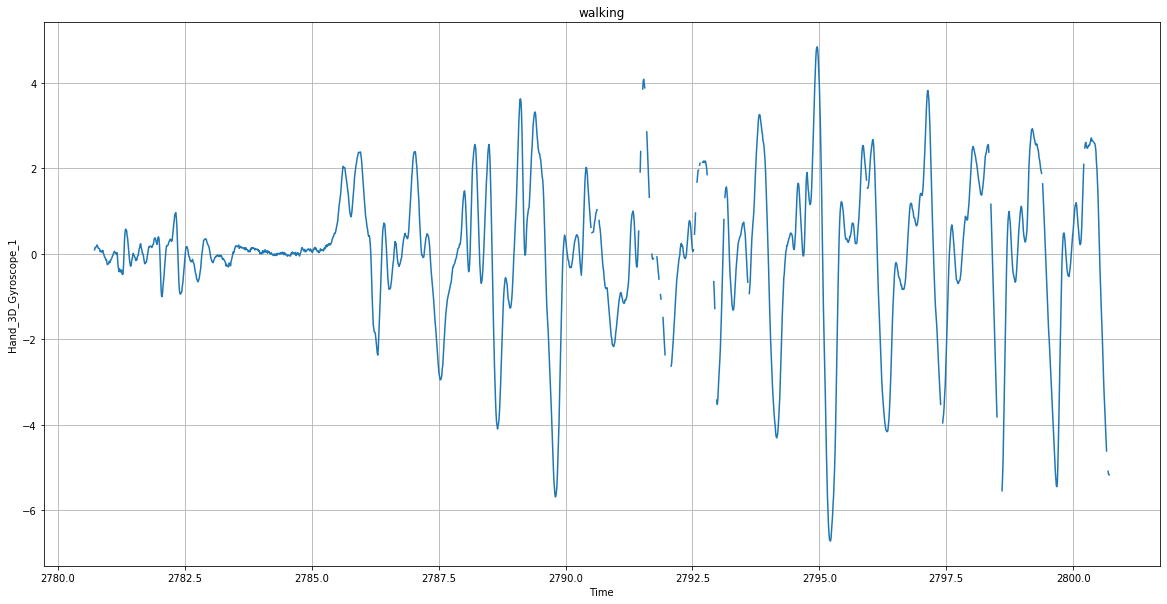

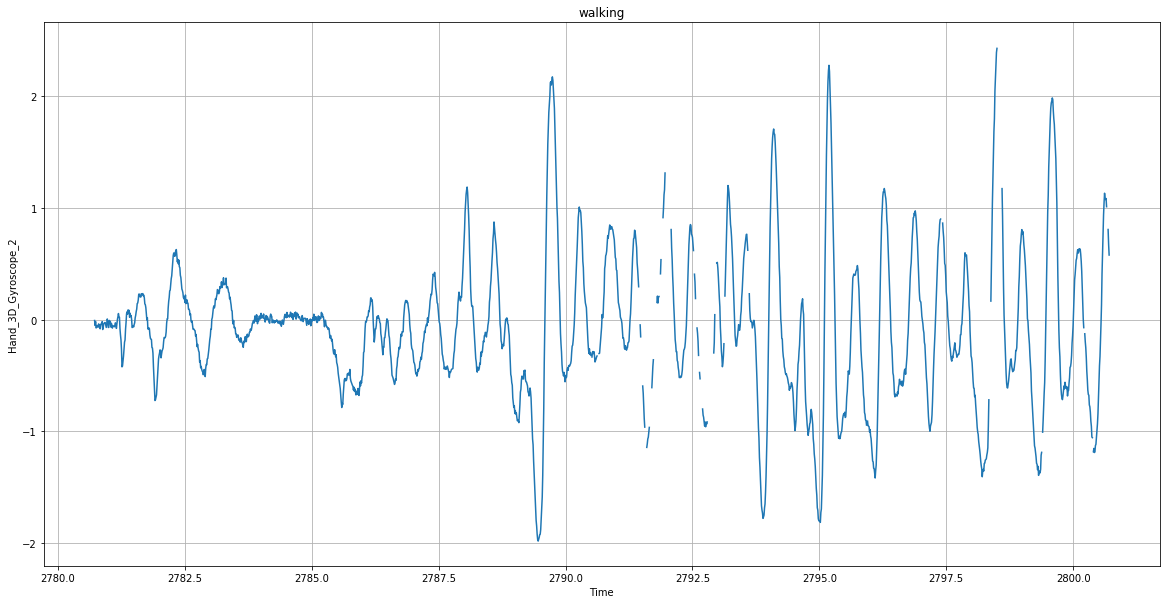

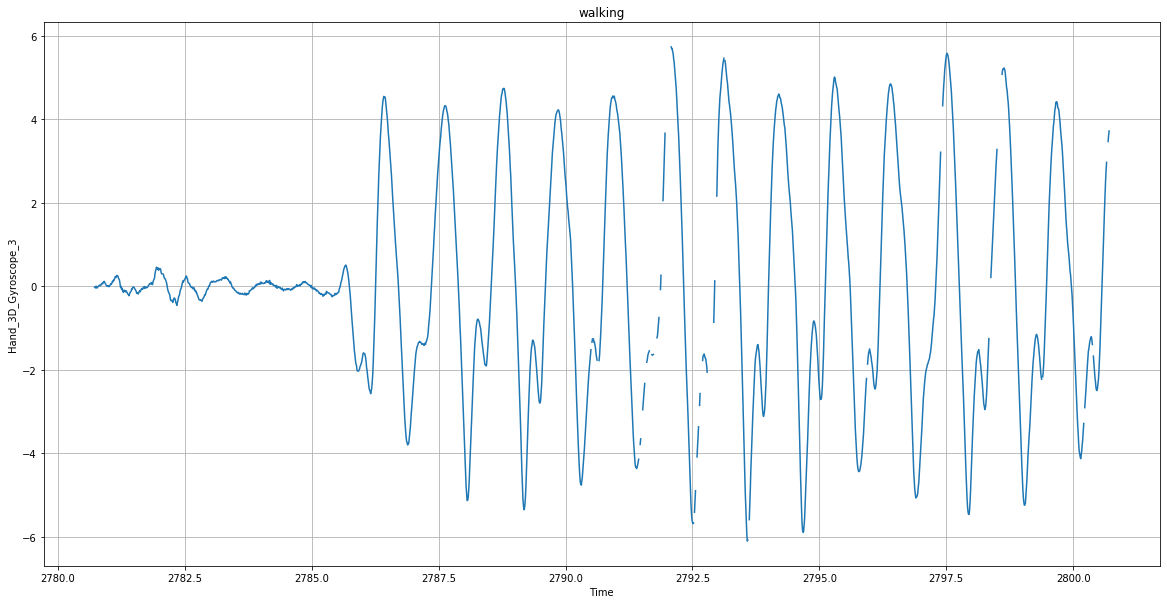

In [222]:
print_available_activities(df_102, 102)
print_sensor_graphs2(df_102, 'walking', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 10))

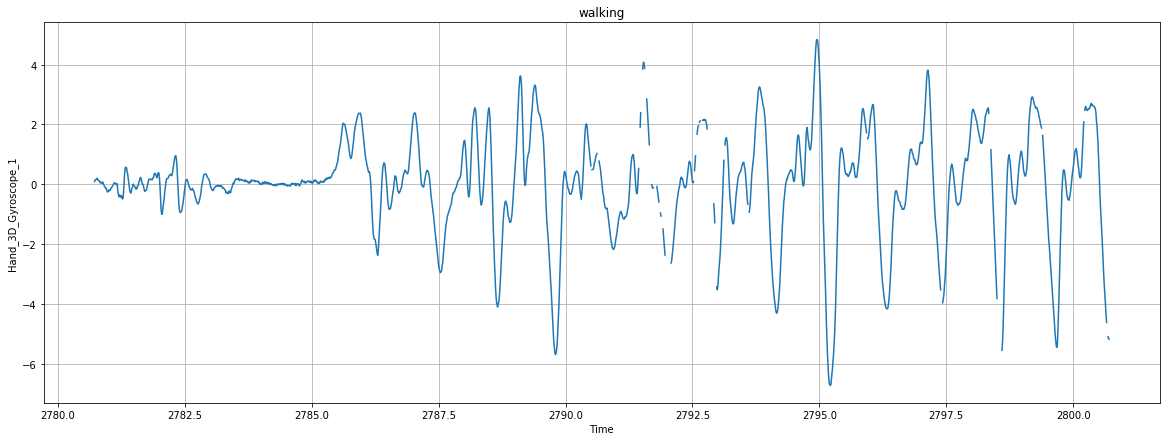

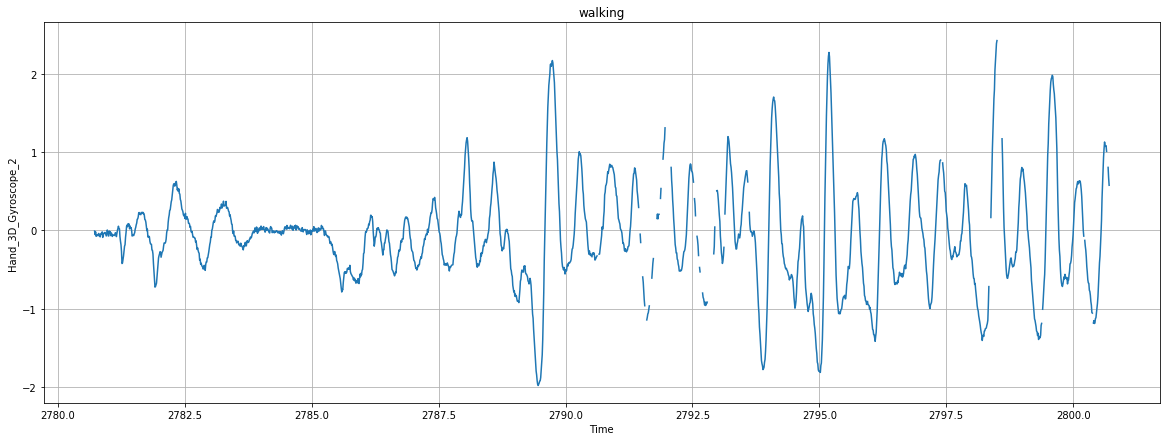

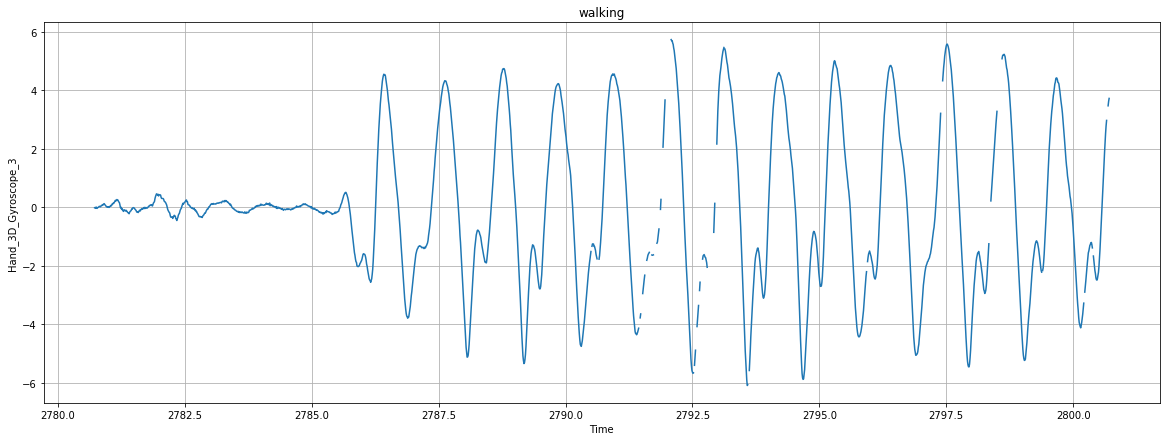

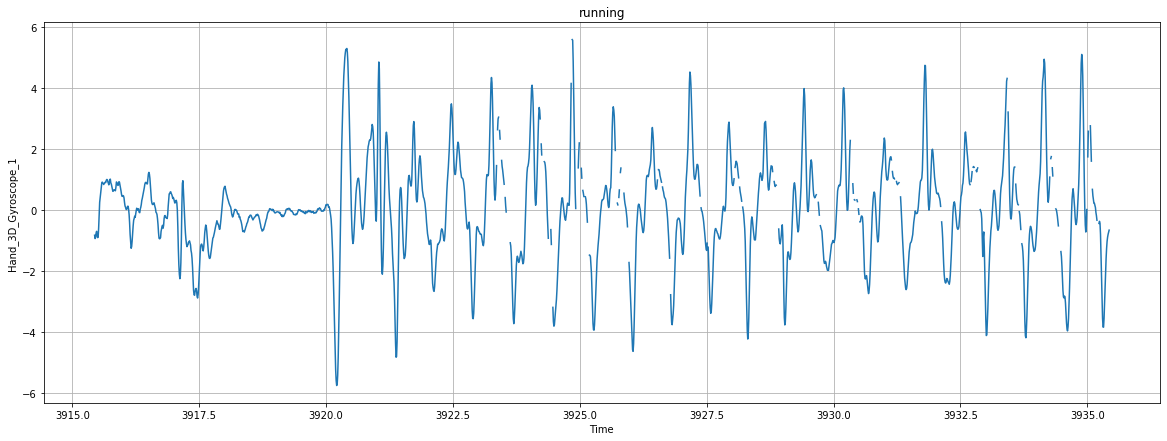

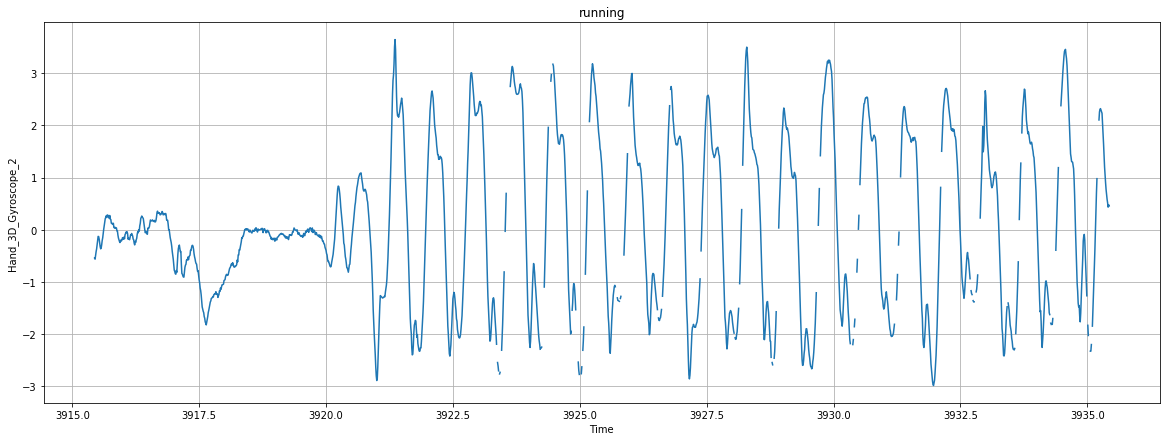

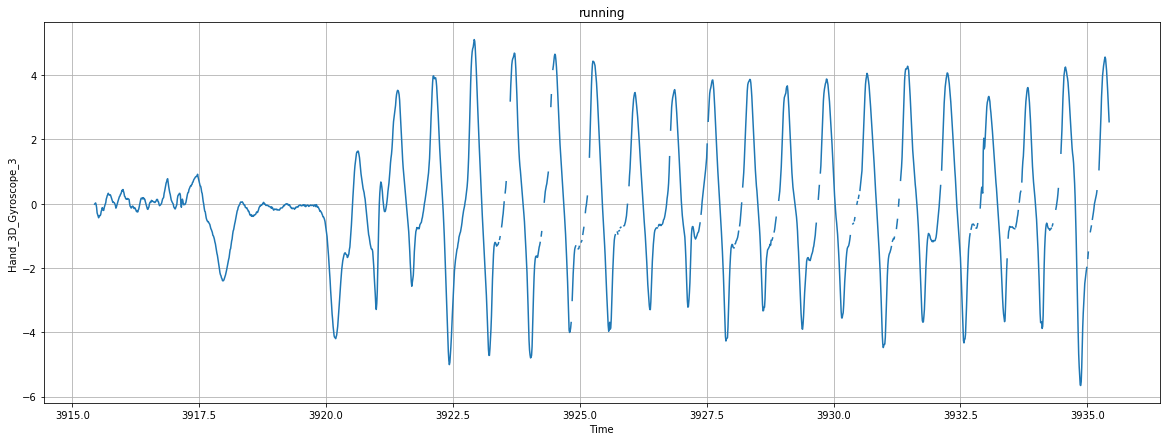

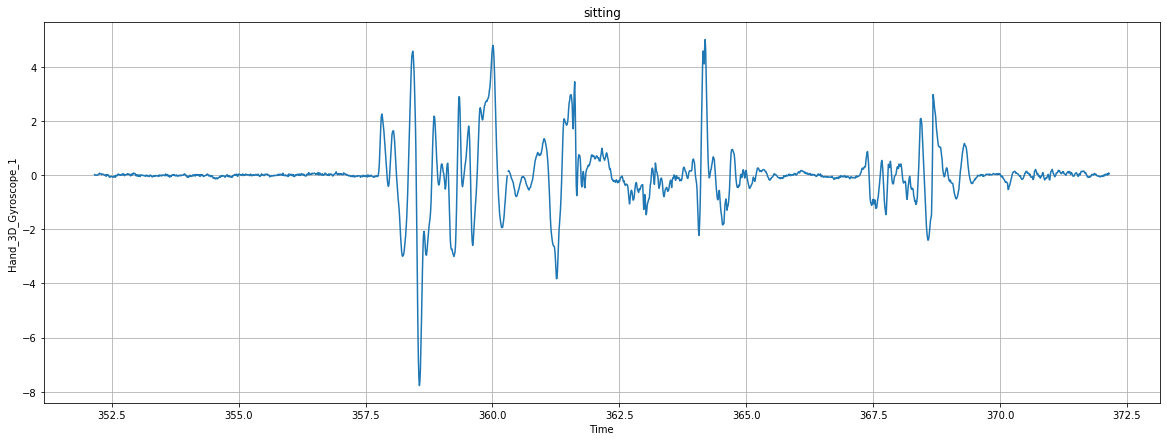

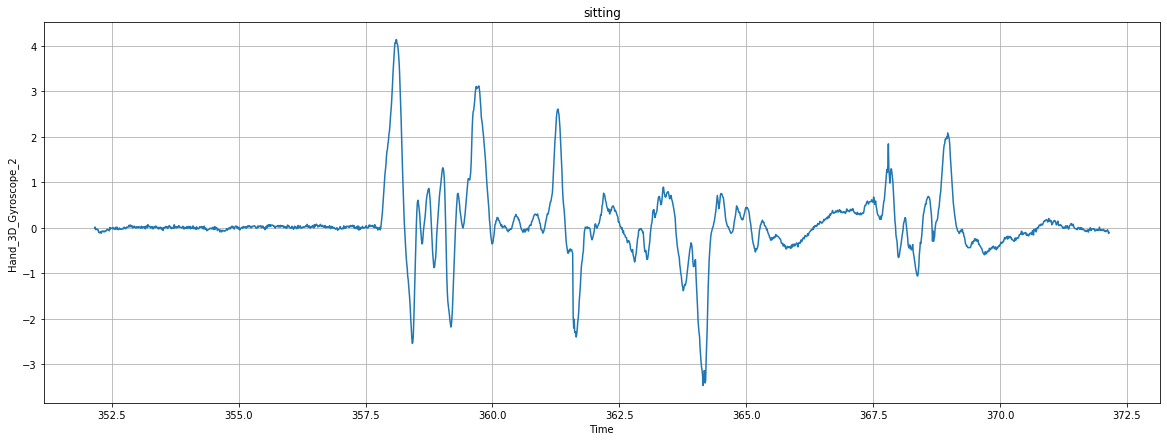

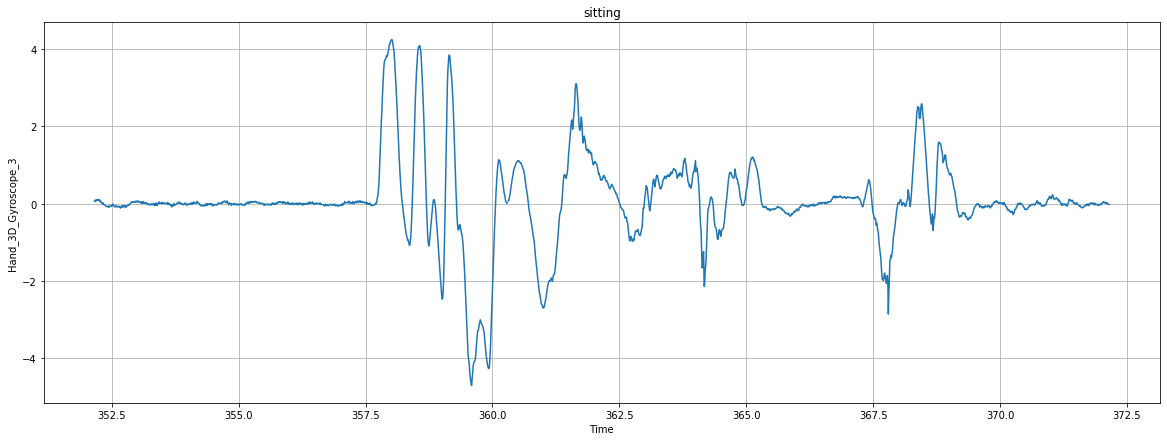

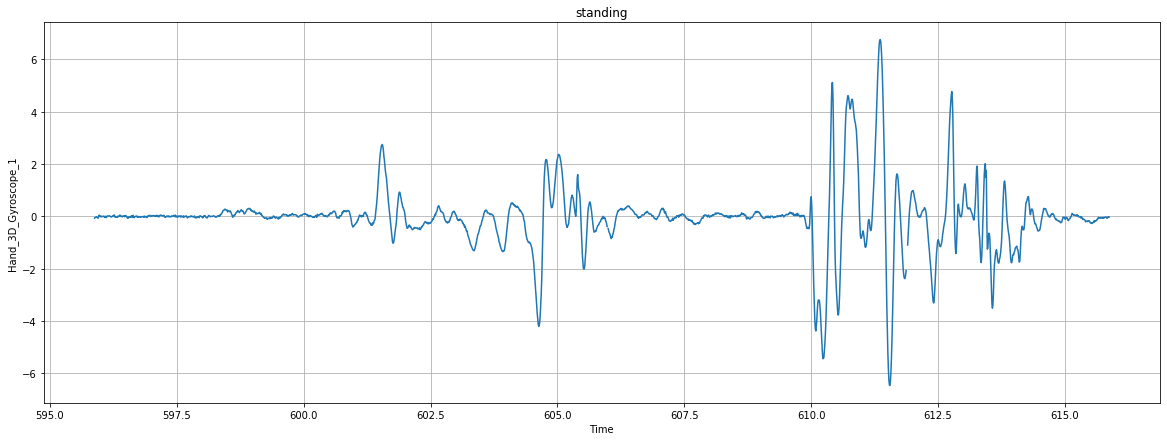

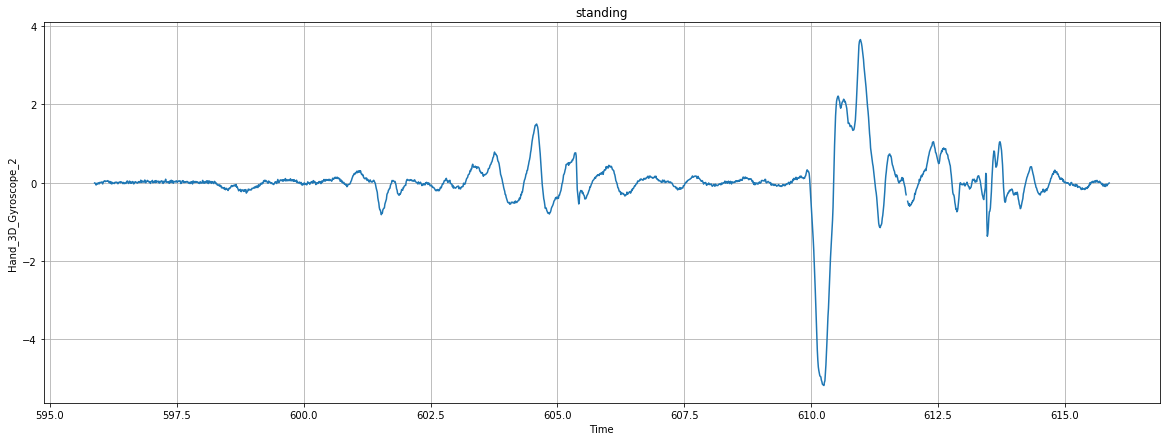

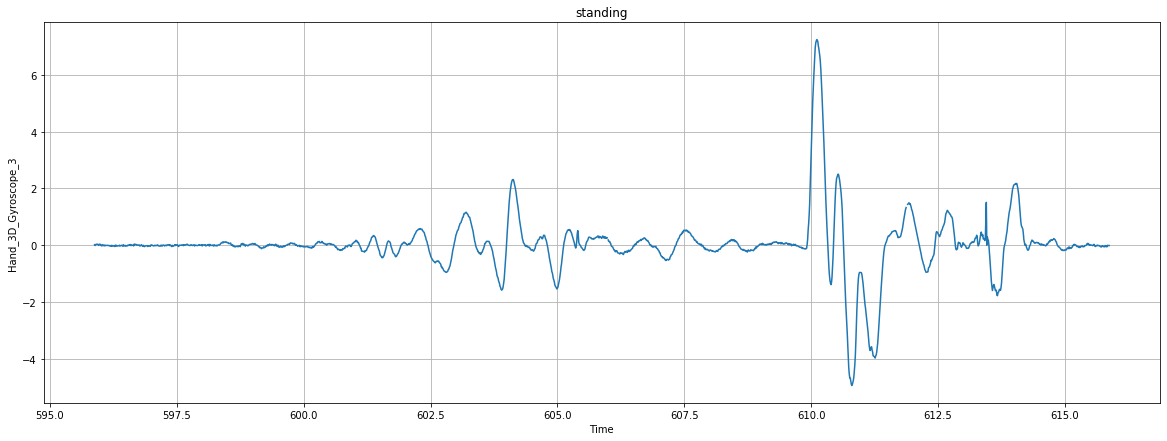

In [221]:
print_sensor_graphs(df_102, 'walking', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))
print_sensor_graphs(df_102, 'running', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))
print_sensor_graphs(df_102, 'sitting', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))
print_sensor_graphs(df_102, 'standing', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))

По графикам видно, что серии пропусков в значениях гироскопа можно заполнить используя ближайшие значения, в которых нет пропусков